In [2]:
# basic
import numpy as np
import pandas as pd 
import datetime as dt 
from pandas_datareader import data as pdr 

# regression
import  statsmodels.api  as sm 

# visulization
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 

What is Beta?

An asset's beta to another asset is just the $\beta$ from the above model. 
For instance, if we regressed TSLA against the S&P 500 using the model $Y_{TSLA} = \alpha + \beta X$, then TSLA's beta exposure to the S&P 500 would be that beta. 
If we used the model $Y_{TSLA} = \alpha + \beta X_{SPY} + \beta X_{AAPL}$, 
then we now have two betas, one is TSLA's exposure to the S&P 500 and one is TSLA's exposure to AAPL.


--> Often "beta" will refer to a stock's beta exposure to the S&P 500. We will use it to mean that unless otherwise specified.

In [3]:
class Ken_French_Library():
    """
    Fama/French 3 Factors [Weekly]
    Fama/French 3 Factors [Daily]
    """

    def __init__(self,start,periods):

        self.start = start 
        self.periods = periods
    
    def get_data(self):

        research_factors = pdr.DataReader('F-F_Research_Data_Factors_'+str(self.periods),
                                      'famafrench', start=self.start)[0] 
        momentum_factor = pdr.DataReader('F-F_Momentum_Factor_daily',
                                     'famafrench', start=self.start)[0]

        five_factors = research_factors.join(momentum_factor).dropna()
        five_factors /= 100.
        five_factors.index = five_factors.index.tz_localize('utc')

        five_factors.columns = five_factors.columns.str.strip()

        self.five_factors = pd.DataFrame(five_factors)
        self.five_factors = self.five_factors.reset_index()
        self.five_factors['Date'] = self.five_factors.apply(lambda x : self.Address_Date(x['Date']),axis=1)
        self.five_factors.index   = self.five_factors['Date']
        self.five_factors = self.five_factors.drop(['Date'],axis=1)
        
        return self.five_factors
    
    def Address_Date(self,date):
        
        date = str(date)
        return date[:10]
        

    def __len__(self):
        return self.five_factors.shape[0]


Fama_French =  Ken_French_Library(start=dt.datetime(2012,1,1),periods='Daily')
FF_DF       =  Fama_French.get_data()
FF_DF

,Mkt-RF,SMB,HML,RF,Mom
Date,,,,,
2012-01-03,0.0150,-0.0020,0.0094,0.0,-0.0261
2012-01-04,0.0000,-0.0064,0.0003,0.0,0.0011
2012-01-05,0.0039,0.0018,0.0019,0.0,-0.0059
2012-01-06,-0.0019,0.0002,-0.0026,0.0,-0.0008
2012-01-09,0.0028,0.0024,-0.0005,0.0,-0.0034
...,...,...,...,...,...
2021-06-24,0.0068,0.0062,0.0023,0.0,0.0071
2021-06-25,0.0032,-0.0068,0.0046,0.0,-0.0058
2021-06-28,0.0023,-0.0048,-0.0159,0.0,0.0011


In [8]:
class Company_Data():
    """
    ticker     --> list (str)
    start ,end --> datetime 
    peirods    --> string
    """
    def __init__(self,tickers,start,end,periods):

        self.start   = start 
        self.end     = end 
        self.tickers = tickers
        self.periods = periods
    
    def get_data(self,ticker):

        self.df = pdr.get_data_yahoo(ticker,self.start,self.end).reset_index()
   
        return self.df 
    
    def Address_Date(self,date):
        
        date = str(date)
        return date[:10]
        
    def get_price_data(self):

        for i , ticker in enumerate(self.tickers) : 
            
            if i == 0 :
                Price_DF = self.get_data(ticker)
                Price_DF = Price_DF[['Date','Close']]
                Price_DF.columns = ['Date',str(ticker)]
            else:
                Merge_DF = self.get_data(ticker)[['Date','Close']]
                Merge_DF.columns = ['Date',str(ticker)]
                Price_DF = Price_DF.merge(Merge_DF,how='outer')
        
        Price_DF = Price_DF.fillna(value=0)
        Price_DF['Date'] = Price_DF.apply(lambda x : self.Address_Date(x['Date']),axis=1)
        Price_DF.index = Price_DF['Date']
        Price_DF = Price_DF.drop(['Date'],axis=1)

        return Price_DF

# ------------ Company_DF parameters ------------ 
start   = dt.datetime(2012,1,1)
end     = dt.datetime.now()
tickers = ["UBS"]

# ------------ ------------ ------------ ------------ 

Company_Price = Company_Data(tickers=tickers,start=start,end=end,periods="Daily")
Stock_DF      = Company_Price.get_price_data()
print(Stock_DF)

                  UBS
Date                 
2012-01-03  12.380000
2012-01-04  12.330000
2012-01-05  11.880000
2012-01-06  11.620000
2012-01-09  11.280000
...               ...
2021-08-16  17.070000
2021-08-17  16.870001
2021-08-18  16.780001
2021-08-19  16.580000
2021-08-20  16.620001

[2425 rows x 1 columns]


In [56]:
def Single_Asset_with_FF(Stock_DF,Ticker,Fama_French_DF):

    # built return
    Output_DF            = Stock_DF[str(Ticker)].reset_index(name=str(Ticker) ) # a portfolio return
    Output_DF['Return']  = Output_DF[str(Ticker)].pct_change()
    Output_DF = Output_DF.dropna()

    # set index
    Output_DF.index = Output_DF['Date']
    Output_DF = Output_DF.drop(['Date'],axis=1)
    Output_DF = pd.merge(Output_DF,Fama_French_DF,how='inner',left_index=True, right_index=True)

    return Output_DF


regression_df = Single_Asset_with_FF(Stock_DF=Stock_DF,Ticker='UBS',Fama_French_DF=FF_DF)
regression_df

,UBS,Return,Mkt-RF,SMB,HML,RF,Mom
Date,,,,,,,
2012-01-04,12.33,-0.004039,0.0000,-0.0064,0.0003,0.0,0.0011
2012-01-05,11.88,-0.036496,0.0039,0.0018,0.0019,0.0,-0.0059
2012-01-06,11.62,-0.021886,-0.0019,0.0002,-0.0026,0.0,-0.0008
2012-01-09,11.28,-0.029260,0.0028,0.0024,-0.0005,0.0,-0.0034
2012-01-10,11.76,0.042553,0.0097,0.0039,0.0041,0.0,-0.0112
...,...,...,...,...,...,...,...
2021-06-24,15.66,0.010975,0.0068,0.0062,0.0023,0.0,0.0071
2021-06-25,15.68,0.001277,0.0032,-0.0068,0.0046,0.0,-0.0058
2021-06-28,15.55,-0.008291,0.0023,-0.0048,-0.0159,0.0,0.0011


( ㄧ. ) Market Risk Exposure

More generally, this beta gets at the concept of how much risk exposure you take on by holding an asset. If an asset has a high beta exposure to the Market , then while it will do very well while the market is rising, it will do very poorly when the market falls. A high beta corresponds to high speculative risk. You are taking out a more volatile bet.

when constuct strategy , value stratgies that have negligible beta exposure to as many factors as possible. What this means is that all of the returns in a strategy lie in the $\alpha$ portion of the model, and are independent of other factors. 

This is highly desirable, as it means that the strategy is independent to market conditions. It will make money equally well in a crash as it will during a bull market. These strategies are the most attractive to individuals with huge cash pools such as endowments and soverign wealth funds.

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     1452.
Date:                Sun, 22 Aug 2021   Prob (F-statistic):          1.55e-248
Time:                        14:42:57   Log-Likelihood:                 6503.4
No. Observations:                2388   AIC:                        -1.300e+04
Df Residuals:                    2386   BIC:                        -1.299e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.398      0.1

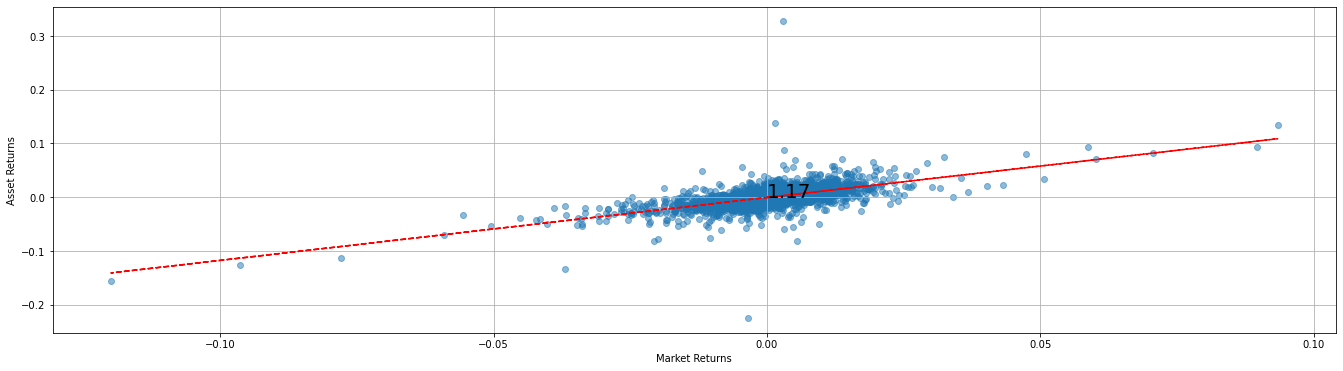

In [57]:
import statsmodels.api as sm 

x = regression_df['Mkt-RF']
y = regression_df['Return']

def OLS_Linear_Regression(y,x):

    # linear Regression
    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    res   = model.fit()

    # Print Summary
    print(res.summary())

    return res.params

def Plot_Single_Beta(y,x,estimate_params):

    estimate_returns = np.dot(sm.add_constant(x),estimate_params.values )

    
    fig,ax = plt.subplots(figsize=(23,6))
    ax.scatter(x, y ,alpha=0.5)
    ax.plot(x ,estimate_returns,color='red',linestyle='--')
    ax.annotate(np.round(estimate_params[-1],decimals=3),xy=(0,0),color='black',size=20)

    plt.grid()
    plt.xlabel('Market Returns')
    plt.ylabel('Asset Returns')
    plt.show()

    return fig



params         = OLS_Linear_Regression(y,x)
regression_fig = Plot_Single_Beta(y,x,estimate_params=params)

(二.) Risk Management

The process of reducing exposure to other factors is known as risk management. Hedging is one of the best ways to perform risk management in practice.

(2-1.) Hedging  --> If we determine that our portfolio's returns are dependent on the market via this relation

$$Y_{portfolio} = \alpha + \beta X_{SPY}$$

then we can take out a short position in SPY to try to cancel out this risk. The amount we take out is $-\beta V$ where $V$ is the total value of our portfolio. This works because if our returns are approximated by $\alpha + \beta X_{SPY}$, 

then adding a short in SPY will make our new returns be $\alpha + \beta X_{SPY} - \beta X_{SPY} = \alpha$. 

Our returns are now purely alpha, which is independent of SPY and will suffer no risk exposure to the market.

(2-2.) Market Neutral

When a stragy exhibits a consistent beta of 0, we say that this strategy is market neutral.

(2-3.) Problems with Estimation

The problem here is that the beta we estimated is not necessarily going to stay the same as we walk forward in time . ( Rolling Beta )
As such the amount of short we took out in the SPY may not perfectly hedge our portfolio, and in practice it is quite difficult to reduce beta by a significant amount.

We will talk more about problems with estimating parameters in future lectures. In short, each estimate has a stardard error that corresponds with how stable the estimate is within the observed data.


--> Now assume we have a signle asset portfolio (UBS) , with 10,000 US Dollar , the hedging value will be , beta_market * 10,000 ,
    than our portfolio estimate return will be 

    --> Portfolio_Return * ( invest_value ) = Alpha * ( invest_value ) + ( Beta * Market_Return - Beta * Market_Return ) * ( invest_value ) 

    --> Portfolio_Return * ( invest_value ) = Alpha * ( invest_value ) 
    
    --> Market Neutral --> In this way we hedge the market risk expusure !



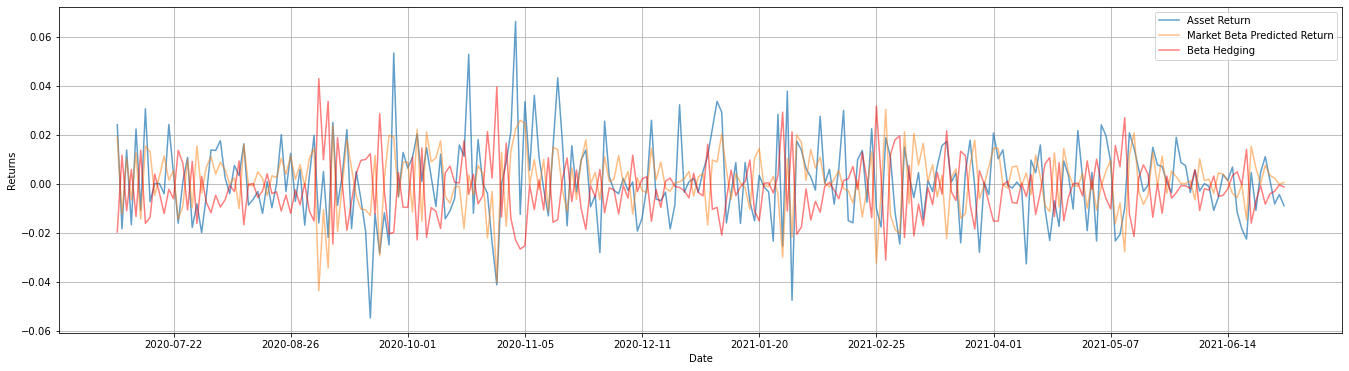

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     32.99
Date:                Sun, 22 Aug 2021   Prob (F-statistic):           2.70e-08
Time:                        14:45:22   Log-Likelihood:                 10045.
No. Observations:                 250   AIC:                        -2.009e+04
Df Residuals:                     248   BIC:                        -2.008e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009    5.5e-20  -1.66e+16      0.0

array([-9.10828187e-04, -3.53449908e-17])

In [60]:
regression_df = regression_df.tail(250)

fig , ax = plt.subplots(figsize=(23,6))
ax.plot(regression_df.index , regression_df['Return'] ,label='Asset Return',alpha=0.7)
ax.plot(regression_df.index , np.dot(sm.add_constant(regression_df['Mkt-RF'].values),params) , label='Market Beta Predicted Return',alpha=0.5)

ax.plot(regression_df.index , params[0] - np.dot(regression_df['Mkt-RF'].values,params[1]) , label='Beta Hedging',alpha=0.5, color='red')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=25))
ax.set_ylabel('Returns')
ax.set_xlabel('Date')
ax.grid()
ax.legend()
plt.show()


# to check wheather the beta had been elimeate by the heding
y = np.dot(sm.add_constant(regression_df['Mkt-RF'].values),params) + params[0] - np.dot(regression_df['Mkt-RF'].values,params[1]) # beta hedging portfolio
x = regression_df['Mkt-RF'].values # market return 
OLS_Linear_Regression(y,x)